In [1]:
import geopandas as gpd
from geopandas.tools import overlay
import os
import matplotlib.pyplot as plt
import boto3
import zipfile
import sys
import xarray as xr

In [2]:
sys.path.append(os.path.expanduser('../../'))
from scripts.utils.write_metadata import (
    make_metadata_files, 
    append_metadata
)

from scripts.utils.file_helpers import to_zarr

In [24]:
import os
import boto3
import geopandas as gpd
import zipfile
import matplotlib.pyplot as plt

def reproject_clip_geospatial(aws_pull_directory, aws_upload_directory, pull_file_name, output_file_name):
    '''
    Pulls a zipped geospatial dataset, identifies each set's coordinate reference system (crs), and reprojects them
    to the Census tract data crs (EPSG:4269). Files are then clipped for the Census tract boundaries, visualized, and uploaded to 
    Amazon Web Services (AWS) as .shp, .shx, .dbf, and .prj files for future analysis.

    Note:
    This function assumes users have configured the AWS CLI such that their access key / secret key pair are stored in ~/.aws/credentials.
    See https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html for guidance
    
    Parameters
    ----------
    aws_pull_directory: str
        folder the data is in within AWS
    aws_upload_directory: str
        directory to place new .shp, .shx, .dbf, and .prj files
    pull_file_name: str
        name of the zipped data
    output_file_name: str
        name of the reprojected, clipped data
    '''
    
    s3_client = boto3.client('s3')  
    bucket_name = 'ca-climate-index'  

    # Specify local file name for download
    local_file_name = 'downloaded_shapefile'

    # Specify the S3 key (path + file) to download
    s3_key = f'{aws_pull_directory}/{pull_file_name}'

    if not os.path.exists(local_file_name):
        # File not found locally, download from S3
        s3_client.download_file(bucket_name, s3_key, local_file_name)

    print(f'Download complete: {local_file_name}')

    # Unzip the downloaded file
    unzip_dir = 'unzipped_data'
    os.makedirs(unzip_dir, exist_ok=True)

    with zipfile.ZipFile(local_file_name, 'r') as zip_ref:
        zip_ref.extractall(unzip_dir)

    print(f'Unzipping complete. Files are in: {unzip_dir}')
    print('')
    print('Pulling large files from AWS, this could take a few minutes...')
    
    print('pulling census data from AWS...')
    # load the census tracts spatial data for California
    census_shp_dir = "s3://ca-climate-index/0_map_data/2021_tiger_census_tract/2021_ca_tract/"
    ca_boundaries = gpd.read_file(census_shp_dir)
    # check the current coordinate system of the census tracts data
    print("Original CRS of Census Tracts Data:")
    print(ca_boundaries.crs)
    print('')
    
    # Iterate through each file in the subfolder
    for filename in os.listdir(unzip_dir):
        if filename.endswith('.shp'):
            input_file_path = os.path.join(unzip_dir, filename)

            # Read the GeoDataFrame
            gdf = gpd.read_file(input_file_path)

    # Print the current CRS
    print(f"Original CRS of the data: {gdf.crs}")
    
    # Create subplots for each iteration
    ax = plt.subplot(111)
    
    # Plot the clipped GeoDataFrame
    gdf.plot(ax=ax)
    
    # Set the title
    plt.title(f"Original data from data")

    # Show the plot for each iteration
    plt.show()
    
    # Reproject to 'ca_boundaries'
    #gdf_reprojected = gdf.to_crs({'init': 'epsg:4269'})
    gdf_reprojected = gdf.to_crs(ca_boundaries.crs)
    
    # Print the CRS information after clipping
    print(f"CRS before clipping: {gdf_reprojected.crs}")
    
    # Set the CRS explicitly
    #gdf_reprojected.crs = {'init': 'epsg:4269'}
    
    # Clip using 'ca_boundaries'
    clipped_gdf = overlay(gdf_reprojected, ca_boundaries, how='intersection')
    print(f"New CRS of {unzip_dir}: {clipped_gdf.crs}")
    print('')

    print(f"CRS after clipping: {clipped_gdf.crs}")

    # Create subplots for each iteration
    ax = plt.subplot(111)
    
    # Plot the clipped GeoDataFrame
    clipped_gdf.plot(ax=ax)
    
    # Set the title
    plt.title(f"Clipped and Reprojected Data")

    # Show the plot for each iteration
    plt.show()

    # Close the figure after the loop
    plt.close()
    
    # Save the clipped GeoDataFrame to a shapefile
    clipped_folder_path = f'{output_file_name}'
    os.makedirs(clipped_folder_path, exist_ok=True)

        # Save the clipped GeoDataFrame to a shapefile with CRS information
    clipped_shapefile_path = f'{clipped_folder_path}/{output_file_name}.shp'
    clipped_gdf.to_file(clipped_shapefile_path, crs=gdf_reprojected.crs)

    # Save the corresponding .shx, .dbf files
    for ext in ['.shx', '.dbf']:
        file_path = f'{clipped_folder_path}/{output_file_name}{ext}'
        clipped_gdf.to_file(file_path)

        # Upload the saved file to AWS
        with open(file_path, 'rb') as data:
            s3_client.upload_fileobj(data, bucket_name, f"{aws_upload_directory}/{output_file_name}/{os.path.basename(file_path)}")

    # Save the .prj file separately
    prj_file_path = f'{clipped_folder_path}/{output_file_name}.prj'
    with open(prj_file_path, 'w') as prj_file:
        prj_file.write('EPSG:4269')

    # Upload the saved .prj file to AWS
    with open(prj_file_path, 'rb') as data:
        s3_client.upload_fileobj(data, bucket_name, f"{aws_upload_directory}/{output_file_name}/{os.path.basename(prj_file_path)}")

    # Upload the saved .prj file to AWS
    with open(clipped_shapefile_path, 'rb') as data:
        s3_client.upload_fileobj(data, bucket_name, f"{aws_upload_directory}/{output_file_name}/{os.path.basename(clipped_shapefile_path)}")

    print(f"Merged and sorted files written to {output_file_name}")


Download complete: downloaded_shapefile
Unzipping complete. Files are in: unzipped_data

Pulling large files from AWS, this could take a few minutes...
pulling census data from AWS...
Original CRS of Census Tracts Data:
EPSG:4269

Original CRS of the data: EPSG:3857


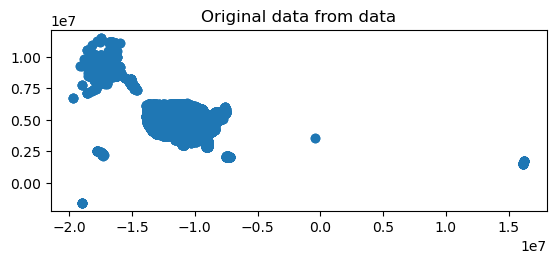

CRS before clipping: EPSG:4269
New CRS of unzipped_data: EPSG:4269

CRS after clipping: EPSG:4269


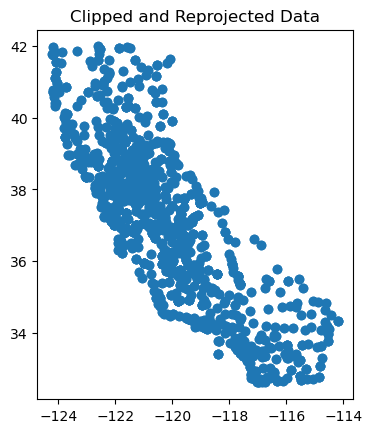

Merged and sorted files written to cellular_tower_reproject


In [25]:
aws_pull_directory = '1_pull_data/built_environment/communication_infrastructure/homeland_infrastructure_foundation_level_data'
aws_upload_directory = '2b_reproject/built_environment/communication_infrastructure/homeland_infrastructure_foundation_level_data'
pull_file_name = 'Cellular_Towers.zip'
output_file_name = 'cellular_tower_reproject'

reproject_clip_geospatial(aws_pull_directory, aws_upload_directory, pull_file_name, output_file_name)

# print crs of new files, getting 'none' 

In [2]:
new_reproject = 'new'
    
    # Iterate through each file in the subfolder
for filename in os.listdir(new_reproject):
    if filename.endswith('.shp'):
        input_file_path = os.path.join(new_reproject, filename)

            # Read the GeoDataFrame
        gdf = gpd.read_file(input_file_path)

print(gdf.crs)

None


In [4]:
origional_file = 'unzipped_data'
    
    # Iterate through each file in the subfolder
for filename in os.listdir(origional_file):
    if filename.endswith('.shp'):
        input_file_path = os.path.join(origional_file, filename)

            # Read the GeoDataFrame
        gdf = gpd.read_file(input_file_path)

print(gdf.crs)    

EPSG:3857
